In [43]:
!nvidia-smi

In [44]:
# !pip uninstall jax -y
# !pip uninstall jaxlib -y
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [45]:
import os
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)

Below it is verified that the GPU is enabled and available. The GPU used is an Nvidia Gigabyte 3090.

In [46]:
import jax
jax.devices()

[CudaDevice(id=0)]

Below a large 10,000 x 10,000 matrix of random floats is instantiated, and a JIT-compiled function is defined to mulitple two matrices.

In [47]:
import jax.numpy as jnp
from jax import random
from jax import device_put, jit
from timeit import default_timer as timer

# Init a large matrix
N = 10_000
# Create a random key
key = random.PRNGKey(0)
# Generate a random NxN matrix
random_matrix = random.uniform(key, (N, N))

# JIT compile 
@jit
def matrix_multiplication(a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
  return a @ b



Below the matrix multiplication is performed `num_runs` times to get an average time for the operation. Note that it is important to run the function atleast once to ensure it has been JIT-compiled for the present device.

In [48]:
# Ensure the matrix is on the CPU
random_matrix_on_cpu = device_put(random_matrix, device=jax.devices('cpu')[0])
print(f"Matrix is on device: {random_matrix_on_cpu.device}")

# Do the matrix multiplication once to ensure the function is JIT-compiled
matrix_multiplication(random_matrix, random_matrix).block_until_ready()

num_runs = 10
cpu_times = []
for _ in range(num_runs):
	start_time = timer()
	result_cpu = matrix_multiplication(random_matrix_on_cpu, random_matrix_on_cpu).block_until_ready()
	end_time = timer()
	cpu_times.append(end_time - start_time)

cpu_times = jnp.asarray(cpu_times[1:])  # Drop the first run as it's usually an outlier
cpu_time = jnp.mean(cpu_times)
print(f"Time taken on CPU: {cpu_time} seconds, std. dev: {jnp.std(cpu_times)}")

Matrix is on device: TFRT_CPU_0


Time taken on CPU: 0.8861164450645447 seconds, std. dev: 0.02476961351931095


Below the same experiment is run on the GPU, yielding a >16x speedup on the GPU as compared with the CPU.

In [49]:
# Ensure the matrix is on the GPU
random_matrix_on_gpu = jax.device_put(random_matrix, device=jax.devices('gpu')[0])
print(f"Matrix is on device: {random_matrix_on_gpu.device}")

# Do the matrix multiplication once to ensure the function is JIT-compiled
matrix_multiplication(random_matrix_on_gpu, random_matrix_on_gpu).block_until_ready()

num_runs = 10
gpu_times = []
for _ in range(num_runs):
    start_time = timer()
    result = matrix_multiplication(random_matrix_on_gpu, random_matrix_on_gpu).block_until_ready()
    end_time = timer()
    gpu_times.append(end_time - start_time)

gpu_times = jnp.asarray(gpu_times[1:])  # Drop the first run as it's usually an outlier
gpu_time = jnp.mean(gpu_times)
print(f"Time taken on CPU: {gpu_time} seconds, std. dev: {jnp.std(gpu_times)}")

Matrix is on device: cuda:0


Time taken on CPU: 0.054210174828767776 seconds, std. dev: 0.001309297396801412


In [50]:
print("Speedup factor:", cpu_time / gpu_time)

Speedup factor: 16.345943


Below is an experiment with varying the matrix size $N$ (giving a square matrix of shame $N \times N$) to test how the speedup factor varies with $N$.

Testing matrix size: 100x100. Number of elemets: 10000
CPU time: 0.000081 seconds
GPU time: 0.000116 seconds
Speedup factor: 0.70
Testing matrix size: 200x200. Number of elemets: 40000
CPU time: 0.000119 seconds
GPU time: 0.000092 seconds
Speedup factor: 1.30
Testing matrix size: 500x500. Number of elemets: 250000
CPU time: 0.001172 seconds
GPU time: 0.000097 seconds
Speedup factor: 12.02
Testing matrix size: 1000x1000. Number of elemets: 1000000
CPU time: 0.003277 seconds
GPU time: 0.000197 seconds
Speedup factor: 16.64
Testing matrix size: 2000x2000. Number of elemets: 4000000
CPU time: 0.011994 seconds
GPU time: 0.000689 seconds
Speedup factor: 17.40
Testing matrix size: 5000x5000. Number of elemets: 25000000
CPU time: 0.114506 seconds
GPU time: 0.007608 seconds
Speedup factor: 15.05
Testing matrix size: 6000x6000. Number of elemets: 36000000
CPU time: 0.207559 seconds
GPU time: 0.012596 seconds
Speedup factor: 16.48
Testing matrix size: 7000x7000. Number of elemets: 49000000
CPU ti

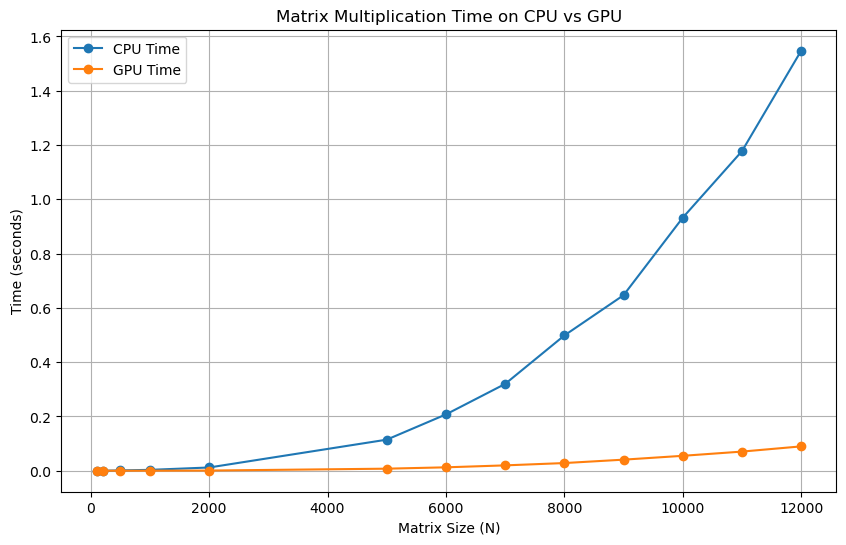

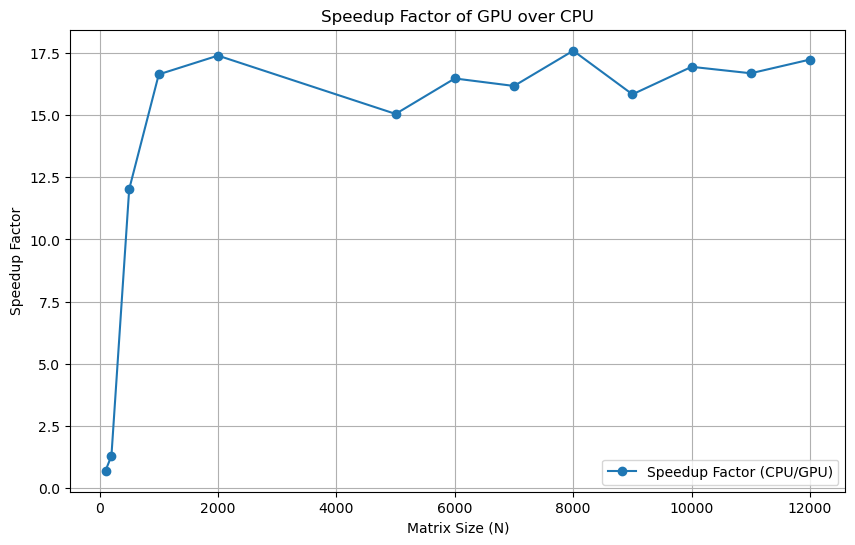

In [51]:
import jax
import jax.numpy as jnp
from jax import random, device_put, jit
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# JIT compile the matrix multiplication function
@jax.jit
def matrix_multiplication(a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
    return a @ b

# Function to measure time taken for matrix multiplication on CPU
def measure_cpu_time(matrix: jnp.ndarray, num_runs: int = 10) -> float:
    cpu_device = jax.devices('cpu')[0]
    matrix_on_cpu = device_put(matrix, device=cpu_device)
    times = []
    # Make sure jit has compiled
    result = matrix_multiplication(matrix_on_cpu, matrix_on_cpu).block_until_ready()
    for _ in range(num_runs):
        start_time = timer()
        result = matrix_multiplication(matrix_on_cpu, matrix_on_cpu).block_until_ready()
        end_time = timer()
        times.append(end_time - start_time)
    return sum(times) / num_runs

# Function to measure time taken for matrix multiplication on GPU
def measure_gpu_time(matrix: jnp.ndarray, num_runs: int = 10) -> float:
    gpu_device = jax.devices('gpu')[0]
    matrix_on_gpu = device_put(matrix, device=gpu_device)
    times = []
    # Make sure jit has compiled
    result = matrix_multiplication(matrix_on_gpu, matrix_on_gpu).block_until_ready()
    for _ in range(num_runs):
        start_time = timer()
        result = matrix_multiplication(matrix_on_gpu, matrix_on_gpu).block_until_ready()
        end_time = timer()
        times.append(end_time - start_time)
    return sum(times) / num_runs


# List of matrix sizes to test
matrix_sizes = [100, 200, 500, 1000, 2000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000, 11_000, 12_000]

# Lists to store times and speedup factors
cpu_times = []
gpu_times = []
speedup_factors = []

# Create a random key
key = random.PRNGKey(0)

# Measure times and speedup factors for each matrix size
for N in matrix_sizes:
    print(f"Testing matrix size: {N}x{N}. Number of elemets: {N*N}")
    matrix = random.uniform(key, (N, N))

    # Measure CPU time
    cpu_time = measure_cpu_time(matrix)
    cpu_times.append(cpu_time)

    # Measure GPU time
    gpu_time = measure_gpu_time(matrix)
    gpu_times.append(gpu_time)

    # Calculate speedup factor
    speedup_factor = cpu_time / gpu_time
    speedup_factors.append(speedup_factor)

    print(f"CPU time: {cpu_time:.6f} seconds")
    print(f"GPU time: {gpu_time:.6f} seconds")
    print(f"Speedup factor: {speedup_factor:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(jnp.array(matrix_sizes), cpu_times, label='CPU Time', marker='o')
plt.plot(matrix_sizes, gpu_times, label='GPU Time', marker='o')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Time (seconds)')
plt.title('Matrix Multiplication Time on CPU vs GPU')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, speedup_factors, label='Speedup Factor (CPU/GPU)', marker='o')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Speedup Factor')
plt.title('Speedup Factor of GPU over CPU')
plt.legend()
plt.grid(True)
plt.show()

From the charts above we see that the speedup factor is less significant for small $N$, increases rapidly and by about $N=1000$ the speedup factor has leveled off at around 16x.